1. Install symforce

In [1]:
%%bash
pip install symforce

2. Inialisasi library yang dibutuhkan

In [2]:
import symforce

symforce.set_epsilon_to_symbol()

import numpy as np
from symforce import typing as T
from symforce.values import Values

3. Menambahkan fungsi initial values

In [3]:
def build_initial_values() -> T.Tuple[Values, int, int]:
    """
    Creates a Values with numerical values for the constants in the problem, and initial guesses
    for the optimized variables
    """
    num_poses = 3
    num_landmarks = 3

    initial_values = Values(
        poses=[sf.Pose2.identity()] * num_poses,
        landmarks=[sf.V2(-2, 2), sf.V2(1, -3), sf.V2(5, 2)],
        distances=[1.7, 1.4],
        angles=np.deg2rad([[55, 245, -35], [95, 220, -20], [125, 220, -20]]).tolist(),
        epsilon=sf.numeric_epsilon,
    )

    return initial_values, num_poses, num_landmarks

4. Menambahkan fungsi residual 

In [4]:
import symforce.symbolic as sf


def bearing_residual(
    pose: sf.Pose2, landmark: sf.V2, angle: sf.Scalar, epsilon: sf.Scalar
) -> sf.V1:
    """
    Residual from a relative bearing measurement of a 2D pose to a landmark.
    """
    t_body = pose.inverse() * landmark
    predicted_angle = sf.atan2(t_body[1], t_body[0], epsilon=epsilon)
    return sf.V1(sf.wrap_angle(predicted_angle - angle))


def odometry_residual(
    pose_a: sf.Pose2, pose_b: sf.Pose2, dist: sf.Scalar, epsilon: sf.Scalar
) -> sf.V1:
    """
    Residual from the scalar distance between two poses.
    """
    return sf.V1((pose_b.t - pose_a.t).norm(epsilon=epsilon) - dist)

5. Menambahkan fungsi factor dari library symforce

In [5]:
from symforce.opt.factor import Factor


def build_factors(num_poses: int, num_landmarks: int) -> T.Iterator[Factor]:
   
    for i in range(num_poses - 1):
        yield Factor(
            residual=odometry_residual,
            keys=[f"poses[{i}]", f"poses[{i + 1}]", f"distances[{i}]", "epsilon"],
        )

    for i in range(num_poses):
        for j in range(num_landmarks):
            yield Factor(
                residual=bearing_residual,
                keys=[f"poses[{i}]", f"landmarks[{j}]", f"angles[{i}][{j}]", "epsilon"],
            )

6. Membuat fungsi main untuk menampilkan hasil

In [6]:
from symforce.opt.optimizer import Optimizer


def main() -> None:
    # Create a problem setup and initial guess
    initial_values, num_poses, num_landmarks = build_initial_values()

    # Create factors
    factors = build_factors(num_poses=num_poses, num_landmarks=num_landmarks)

    # Select the keys to optimize - the rest will be held constant
    optimized_keys = [f"poses[{i}]" for i in range(num_poses)]

    # Create the optimizer
    optimizer = Optimizer(
        factors=factors,
        optimized_keys=optimized_keys,
        debug_stats=True,  # Return problem stats for every iteration
        params=Optimizer.Params(verbose=True),  # Customize optimizer behavior
    )

    # Solve and return the result
    result = optimizer.optimize(initial_values)

    # Print some values
    print(f"Num iterations: {len(result.iteration_stats) - 1}")
    print(f"Final error: {result.error():.6f}")

    for i, pose in enumerate(result.optimized_values["poses"]):
        print(f"Pose {i}: t = {pose.position()}, heading = {pose.rotation().to_tangent()[0]}")

    # Plot the result
    # TODO(hayk): mypy gives the below error, but a relative import also doesn't work.
    # Skipping analyzing "symforce.examples.robot_2d_localization.plotting":
    #     found module but no type hints or library stubs
    from symforce.examples.robot_2d_localization.plotting import plot_solution

    plot_solution(optimizer, result)

7. Memanggil fungsi main

Num iterations: 8[2022-12-04 08:40:25.157] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 6.396/2.952/2.282, rel reduction: 0.64328

Final error: 0.000220
Pose 0: t = [[-0.58303818]
 [-0.82449079]], heading = [1.073486]
Pose 1: t = [[ 1.01671023]
 [-0.23835618]], heading = [0.85760621]
Pose 2: t = [[1.79784992]
 [0.92055145]], heading = [0.67637098]
[2022-12-04 08:40:25.158] [info] LM<sym::Optimize> [iter    1] lambda: 2.500e-01, error prev/linear/new: 2.282/0.088/0.074, rel reduction: 0.96768
[2022-12-04 08:40:25.159] [info] LM<sym::Optimize> [iter    2] lambda: 6.250e-02, error prev/linear/new: 0.074/0.007/0.007, rel reduction: 0.91152
[2022-12-04 08:40:25.159] [info] LM<sym::Optimize> [iter    3] lambda: 1.562e-02, error prev/linear/new: 0.007/0.001/0.001, rel reduction: 0.90289
[2022-12-04 08:40:25.160] [info] LM<sym::Optimize> [iter    4] lambda: 3.906e-03, error prev/linear/new: 0.001/0.000/0.000, rel reduction: 0.61885
[2022-12-04 08:40:25.160] [i

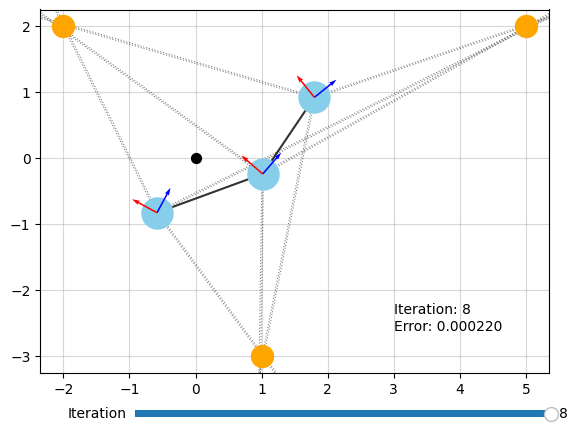

In [7]:
if __name__ == "__main__":
    main()